# Classification.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## NOTE: The classification files folder must be found in the same folder as this code. 

In [1]:
#Import necessary libraries. Strategy: Find HoG features of each image and build SVM with them.
#For second classifier, try Kmeans or Kneighboors
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import  random as rand
from sklearn import svm
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

#from sklearn.neighbors import KNeighborsClassifier

#Declare Constants
CLASSIFY_DIM = (128,128)   #Size of the training images
KCROSSVALID_NUM = 10       #Number of bins when doing k-cross validation

## 2. Classification
### Loading and resizing images && Compute HOG features of all images.

In [2]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

#Create function to save classifier
def saveCLF(clf,path):
    joblib.dump(clf,path)
    
#Create function to load classifier
def loadCLF(path):
    return joblib.load(path)

#Class to hold the feature data and the label
class labeledData():
    def __init__(self,data,label,num):
        self.data = data
        self.label = label
        self.num = num

In [ ]:
#Import training images
folder = "./MIO-TCD-Classification/train/"
vehicleName = [
    "articulated_truck", "background", "bicycle",
    "bus", "car", "motorcycle", "non-motorized_vehicle",
    "pedestrian", "pickup_truck", "single_unit_truck", "work_van"                
]
vehicleDir  = [                                  #Main Directory of Training images
    "articulated_truck",        #10346 imgs
    "background",               #160000 imgs
    "bicycle",                  #2284 imgs
    "bus",                      #10316 imgs
    "car",                      #260518 imgs
    "motorcycle",               #1982 imgs
    "non-motorized_vehicle",    #1751 imgs
    "pedestrian",               #6262 imgs
    "pickup_truck",             #50906 imgs
    "single_unit_truck",        #5120 imgs
    "work_van"                 #9679 imgs
]                 
#Some vehicletypes are commented out as they take too much time to load. After writing code, will remove comment.

vehicleTypes = {}                                #This is the main hash that will map the vehicles type to a number. Maps string to index.
vehicleImgArr,vehicleLabels,hogArr = [],[],[]
idx = 0

#Build Hash Table
for bucket in os.listdir(folder):
    vehicleTypes[bucket] = idx
    idx +=1

#HOG features parameters
cell_size = (16,16)  # h x w in pixels #Changed from 4x4 to 16x16 to speed up process. 
block_size = (2,2)  # h x w in cells
nbins = 8  # number of orientation bins

#Loop across directory to fetch all images
savingPath = "./bin/ImgArr.data"
start = time.time()
if(not os.path.isfile(savingPath)):
    for typeName in vehicleDir:
        vehicleTypeDir = folder + typeName+"/"
        print("Presently loading & finding HOG features of " + str(len(os.listdir(vehicleTypeDir))) + " images from: " + typeName,end="")
        presentTime = time.time()

        #fetch images
        for imgPath in os.listdir(vehicleTypeDir):
            img = cv2.imread(vehicleTypeDir+imgPath)
            img = cv2.resize(img,CLASSIFY_DIM)                          #Resize images so that they are all CLASSIFY_DIM in size
            vehicleImgArr.append(img)                                  #Commented this out to save processing time. 
            vehicleLabels.append(vehicleTypes[typeName])                #Have a seperate array with the labels.
            hogArr.append(HoGFromImage(img,cell_size,block_size,nbins)) #Find Hog Features
        endTime = time.time()
        print(". (Time taken: ", endTime - presentTime,"secs)")
    hogArr = np.asarray(hogArr)
    vehicleLabels = np.asarray(vehicleLabels)
    
    #Saving files:
    print("Saving...",end = "")
    savingPath = "./bin/ImgArr.data"      #Img Data
    joblib.dump(vehicleImgArr,savingPath)
    savingPath = "./bin/HogArr.data"      #Hog Arr
    joblib.dump(hogArr,savingPath)
    savingPath = "./bin/LabelsArr.data"      #labels Arr
    joblib.dump(vehicleLabels,savingPath)
    print("DONE!")
else:
    print("Presently loading saved binary of images/HOG features and labels ...",end = "")
    savingPath = "./bin/ImgArr.data"      #Img Data
    vehicleImgArr = joblib.load(savingPath)
    savingPath = "./bin/HogArr.data"      #Hog Arr
    hogArr = joblib.load(savingPath)
    savingPath = "./bin/LabelsArr.data"      #labels Arr
    vehicleLabels = joblib.load(savingPath)
    print("DONE!")
end = time.time()

#Print out report:
print("REPORT: \n\tTotal Number of images:",len(hogArr),"\n\tTotal time taken: ",end-start,"sec")


Presently loading & finding HOG features of 10346 images from: articulated_truck. (Time taken:  24.70312809944153 secs)
Presently loading & finding HOG features of 160000 images from: background. (Time taken:  533.0485818386078 secs)
Presently loading & finding HOG features of 2284 images from: bicycle. (Time taken:  11.836576223373413 secs)
Presently loading & finding HOG features of 10316 images from: bus. (Time taken:  110.18090343475342 secs)
Presently loading & finding HOG features of 260518 images from: car

#### Preview of Image and its HOG features

Example of test image and its hog features:


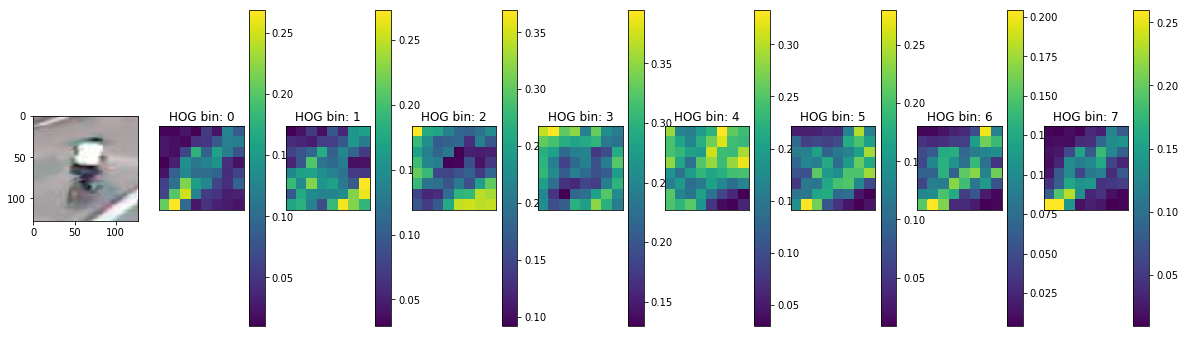

In [5]:
# Preview image and its hog features
preview = 1001
print("Example of test image and its hog features:")
plt.figure(figsize = (20,20))
plt.subplot(191)
plt.imshow(vehicleImgArr[preview])
for bin in range(nbins):
    plt.subplot(192+bin)
    plt.pcolor(hogArr[preview][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

**Discussion:**  
All images are loaded inside *vehicleImgArr* with its HOG features being computed-&-loaded inside *hogArr*. The features that are calculted are of size (8,8,8) meaning that for 8 angular directions, 8x8 array of hog features were calculated for each images (see above for the preview of what sample image with its hog features look like). Therefore, for each image, features of size $8^3 = 512$ are calculated. 

## Classifier #1: SVM
#### Creating classifier

In [6]:
#Building filepath
savingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
name = "SVMclf"+ "_Main"
path = savingPath + name +clfFileType

#Build classifier if it doesn't already exist
if(not os.path.isfile(path)):
    #Creating main classifier that is trained with all training images. 
    dataSVM = hogArr.reshape(len(hogArr),-1)
    labelsSVM = vehicleLabels.reshape(-1)

    #Train SVM classifier
    print("Building the main SVM classifier ...",end = '')
    pTime = time.time()
    clfMain = svm.SVC(gamma=0.001, C=100.)
    clfMain.fit(dataSVM, labelsSVM)
    eTime = time.time()
    print("DONE!")
    print("Time taken to build main SVM classifier:",eTime-pTime,"sec")

    #Saving main SVM classifier
    saveCLF(clfMain,path)

#If the file already exist, just load the classifier instead of building a new one (saves a lot of time)
else:
    print("Loading main SVM classifier ...",end = '')
    clfMain = loadCLF(path)
    print("DONE!")

Loading main SVM classifier ...DONE!


**Discussion:**  
In order to avoid always rebuilding the same classifier everytime, logic has been added to load an already saved version of the calssifier. The main SVM classifier is saved as *./Classifiers/SVM/SVMclf_Main.clf*. To build a new classifier, please delete that file before running the jupyter cell above. 

## Classifier #2: Viola-Jones? Kmeans? K-NearestNeighboor?

## 2.1 Classifier evaluation
### 2.1.1 Evaluating SVM

#### Creating k-bin classifiers

In [ ]:
#USING K-CROSSVALIDATION
#BUILDING ARRAY OF SIZE K WITH ALL K-CLASSIFIERS 

#Reshape the data to be a NxD array
data = hogArr.reshape(len(hogArr),-1)
labels = vehicleLabels.reshape(len(vehicleLabels),-1)

#create labeled data for shuffling if it isn't already saved; else used saved and already shuffled version
savingPath = "./Classifiers/SVM/"
dataFileType = ".data"
name = "labeledData_Validation" + str(KCROSSVALID_NUM)
path = savingPath +name+ dataFileType
if(not os.path.isfile(path)):
    #Create a randomized array 
    print("Shuffling labeled data ...",end = '')
    dataAndLabel = [labeledData(data[i],labels[i],i) for i in range(len(data))]
    dataAndLabel = np.asarray(dataAndLabel) 
    rand.shuffle(dataAndLabel)
    print("DONE!")
    print("Saving labeled data ...",end = '')
    joblib.dump(dataAndLabel,path)
    print("DONE!")
else:
    print("Loading labeled data ...",end = '')
    dataAndLabel = joblib.load(path)
    print("DONE!")
    
#split data into training and testing arrays
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k
savingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
clfArr = []
for kIdx in range(k):
    name = "SVMclf_Validation"+ str(kIdx)
    path = savingPath +name+ clfFileType
    #Only create a new classifier if it hasn't been built before (implemented as such because they take a long time to generate)
    if(not os.path.isfile(path)):
        #Creating Training Array
        labeledTrain = np.delete(dataAndLabel,np.arange(kIdx*sizeOfBin,(kIdx+1)*sizeOfBin))  #Size of (k-1)*sizeOfBin
        Train = [labeledTrain[i].data for i in range(len(labeledTrain))]
        Train = np.asarray(Train)
        TrainLabel= [labeledTrain[i].label for i in range(len(labeledTrain))]
        TrainLabel = np.asarray(TrainLabel).reshape(-1)

        #Train SVM classifier
        print("Building SVM classifier for testing k-bin =",kIdx,"...",end = '')
        pTime = time.time()
        clf = svm.SVC(gamma=0.001, C=100.)
        clf.fit(Train, TrainLabel)
        clfArr.append(clf)
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to build classifier",kIdx,":",eTime-pTime,"sec)")

        #Saving SVM Classifier
        name = "SVMclf_Validation"+ str(kIdx)
        path = savingPath +name+ clfFileType
        saveCLF(clf,path)
    
    #If classifier already exist, just print a statement saying it already exist
    else:
        print("Loading existing SVM classifier for k-bin =", kIdx, "...",end="")
        pTime = time.time()
        clfArr.append(loadCLF(path))
        eTime = time.time()
        print("DONE!",end = " ")
        print("(Time taken to load classifier",kIdx,":",eTime-pTime,"sec)")
        


Loading labeled data ...DONE!
Building SVM classifier for testing k-bin = 0 ...DONE! (Time taken to build classifier 0 : 1336.16374874115 sec)
Building SVM classifier for testing k-bin = 1 ...DONE! (Time taken to build classifier 1 : 1741.7627425193787 sec)
Building SVM classifier for testing k-bin = 2 ...DONE! (Time taken to build classifier 2 : 1816.8927733898163 sec)
Building SVM classifier for testing k-bin = 3 ...DONE! (Time taken to build classifier 3 : 1881.1451733112335 sec)
Building SVM classifier for testing k-bin = 4 ...

#### Predicting labels

In [13]:
#Setting important variables
loadingPath = "./Classifiers/SVM/"
clfFileType = ".clf"
dataFileType = ".data"
k = KCROSSVALID_NUM
sizeOfBin = len(dataAndLabel) // k

#loading randomized labeled data that was used to train classifiers. Used to make sure that training images aren't used for testing
path = loadingPath + "labeledData_Validation" + str(k) + dataFileType
dataAndLabel = joblib.load(path)

#Predicting the Test data
accuracyArr = []
confusionPredArr = np.asarray([])
confusionActualArr = np.asarray([])
for kIdx in range(k):
    #Loading K-cross validation classifier
    clf = clfArr[kIdx]
    
    #Building test arrays
    labeledTest  = dataAndLabel[kIdx*sizeOfBin:(kIdx+1)*sizeOfBin]  #Size of sizeofBin
    Test = [labeledTest[i].data for i in range(len(labeledTest))]
    Test = np.asarray(Test)
    TestLabel= [labeledTest[i].label for i in range(len(labeledTest))]
    TestLabel = np.asarray(TestLabel).reshape(-1)
    
    #Predicting the test array
    print("Predicting labels of Test images from k-bin =",kIdx,"...",end = '')
    start = time.time()
    predicted = clf.predict(Test)
    end = time.time()
    print("DONE!", end = " ")
    print("(Time taken to predict images: ",end-start,"sec)")

    #Analizing the predicted labels (Accuracy)
    totalAccuracy = predicted - TestLabel
    accuracy = len(totalAccuracy[np.where(totalAccuracy == 0)])/len(totalAccuracy)
    accuracyArr.append(accuracy)
    
    #Analysing the predicted labels (precision & recall)
    
    #Analysing the predicted labels (confusion matrix)
    confusionActualArr = np.concatenate((confusionActualArr,TestLabel))
    confusionPredArr = np.concatenate((confusionPredArr,predicted))
    

Predicting labels of Test images from k-bin = 0 ...DONE! (Time taken to predict images:  29.73603105545044 sec)
Predicting labels of Test images from k-bin = 1 ...DONE! (Time taken to predict images:  28.91213297843933 sec)
Predicting labels of Test images from k-bin = 2 ...DONE! (Time taken to predict images:  33.384891986846924 sec)
Predicting labels of Test images from k-bin = 3 ...DONE! (Time taken to predict images:  27.631863117218018 sec)
Predicting labels of Test images from k-bin = 4 ...DONE! (Time taken to predict images:  27.308321237564087 sec)
Predicting labels of Test images from k-bin = 5 ...DONE! (Time taken to predict images:  27.435340642929077 sec)
Predicting labels of Test images from k-bin = 6 ...DONE! (Time taken to predict images:  27.546289682388306 sec)
Predicting labels of Test images from k-bin = 7 ...DONE! (Time taken to predict images:  27.347938776016235 sec)
Predicting labels of Test images from k-bin = 8 ...DONE! (Time taken to predict images:  27.360439

#### Evaluating SVM classifier
#### Average classification accuracy across validations, with the standard deviation.

In [10]:
#Creating report of accuracy of all validations
accuracyArr = np.asarray(accuracyArr)
print("REPORT ACCURACY: ")
print("\tMean of accuracy ratios:",np.mean(accuracyArr))
print("\tStandard deviation of accuracy ratios:",np.std(accuracyArr))

REPORT ACCURACY: 
	Mean of accuracy ratios: 0.743558282208589
	Standard deviation of accuracy ratios: 0.008898761135200797


#### Average precision* and recall* across validations. Are these values consistent with the accuracy? Are they more representative of the dataset? In what situations would you expect precision and recall to be a better reflection of model performance than accuracy?

#### A confusion matrix on a validation set. Plot the matrix as an image. Are any of the classes difficult for your classifier? Discuss. 

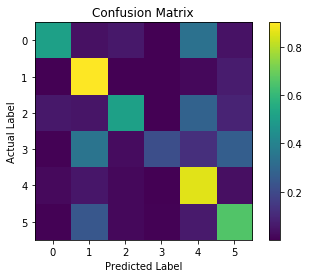

In [30]:
#Obtain non-normalize confusion matrix
confusionMat = confusion_matrix(confusionActualArr,confusionPredArr)

#Normalize confusion matrix across rows. 
confusionMat =  confusionMat.astype('float') / confusionMat.sum(axis=1)[:, np.newaxis]

plt.imshow(confusionMat)
plt.colorbar()
title = "Confusion Matrix"
plt.title(title), plt.xlabel("Predicted Label"), plt.ylabel("Actual Label")
plt.show()